# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from itertools import product
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os

# Configs

## Constant Values

In [59]:
# Add your input and output path
INPUT_PATH = 'datasets/'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

train_list = ['prev_month_demand', 'prev_3week_demand', 'prev_2week_demand', 'prev_week_demand', 'prev_day_demand', 'month', 'day_month', 'day_week']

test_size = 0.5

## Functions

In [4]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path) 
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [5]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )
  
    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])
    
    loc_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )
    
    labels_df = (
        loc_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )
    
    return labels_df

In [6]:
def date_format_modifier(data):  # Year/Month/Day
    data['month'] = data['Date'].dt.month
    data['day_month'] = data['Date'].dt.day
    data['day_week'] = data['Date'].dt.dayofweek
    return data

In [7]:
def train_test_splitting(dataset, test_size):
    start_date = dataset['Date'].min()
    end_date = dataset['Date'].max()
    all_days = end_date - start_date
    
    train_df = dataset[(dataset['Date'] - start_date) < (1 - test_size) * all_days]
    test_df = dataset[(dataset['Date'] - start_date) >= (1 - test_size) * all_days]

    return train_df, test_df

In [8]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [35]:
def add_features(data):  # run after merging datasets and modifing date
    # Lag features
    data['prev_day_demand'] = data.groupby(['Location'])['Demand'].shift(1)
    data['prev_week_demand'] = data.groupby(['Location'])['Demand'].shift(7)
    data['prev_2week_demand'] = data.groupby(['Location'])['Demand'].shift(14)
    data['prev_3week_demand'] = data.groupby(['Location'])['Demand'].shift(21)
    data['prev_month_demand'] = data.groupby(['Location'])['Demand'].shift(28)
    
    data = data.dropna()

    return data

In [10]:
def grid_search(model, test_parameters, train_data, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[train_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [11]:
def model_predict(model, train_data, test_data):

    model.fit(train_data[train_list], train_data['Demand'])


    yhat_train = model.predict(train_data[train_list])
    yhat_test = model.predict(test_data[train_list])

    return yhat_train, yhat_test

In [12]:
def predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [13]:
def evaluation(model_name, train_data, test_data, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], yhat_test)


In [14]:
def day_of_year_modifier(dataset):
    dataset['day_year'] = 0
    start_date = dataset['Date'].min()

    for index, row in dataset.iterrows():
        # Get the day and month values from the current row
        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        dataset.at[index, 'day_year'] = day_number
    return dataset

# Load dataset

In [15]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

# Preprocess

In [16]:
labeled_df = labeling(rides_df)

In [37]:
featured_df = add_features(labeled_df)

In [38]:
dated_df = date_format_modifier(featured_df)
dated_df = day_of_year_modifier(dated_df)

In [60]:
train_df, test_df = train_test_splitting(dated_df, test_size)

In [61]:
train_df

,Location,Date,Demand,prev_day_demand,prev_week_demand,prev_2week_demand,prev_3week_demand,prev_month_demand,month,day_month,day_week,day_year
28,1,2023-01-29,12.0,6.0,11.0,19.0,12.0,40.0,1,29,6,0
29,1,2023-01-30,14.0,12.0,6.0,21.0,14.0,31.0,1,30,0,1
30,1,2023-01-31,8.0,14.0,6.0,18.0,4.0,27.0,1,31,1,2
31,1,2023-02-01,9.0,8.0,7.0,10.0,9.0,7.0,2,1,2,3
32,1,2023-02-02,18.0,9.0,7.0,9.0,8.0,15.0,2,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
31389,265,2023-03-11,65.0,143.0,53.0,81.0,67.0,77.0,3,11,5,41
31390,265,2023-03-12,71.0,65.0,70.0,75.0,67.0,58.0,3,12,6,42
31391,265,2023-03-13,125.0,71.0,116.0,116.0,55.0,88.0,3,13,0,43
31392,265,2023-03-14,122.0,125.0,112.0,104.0,111.0,121.0,3,14,1,44


# Model Training

## **Ridge Regression**

### Grid search to find best hyper parameters

In [62]:
model = Ridge()
best_params, best_score = grid_search(model, {'alpha':[1, 10, 100, 1000, 1000]}, train_df, cv = 5)
print(best_params, best_score)

{'alpha': 1000} -88.64291234692489


In [63]:
model = Ridge(**best_params)
yhat_train, yhat_test = model_predict(model, train_df, test_df)

### Visualization

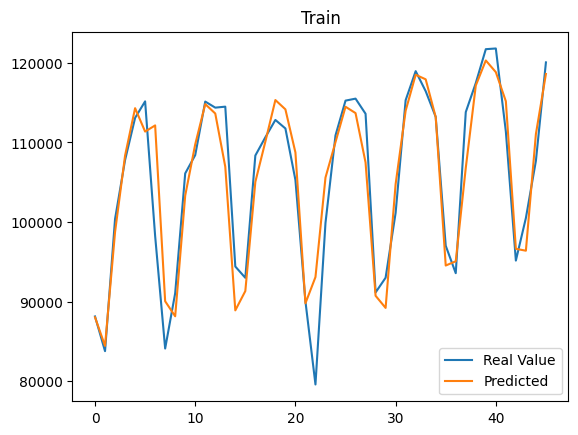

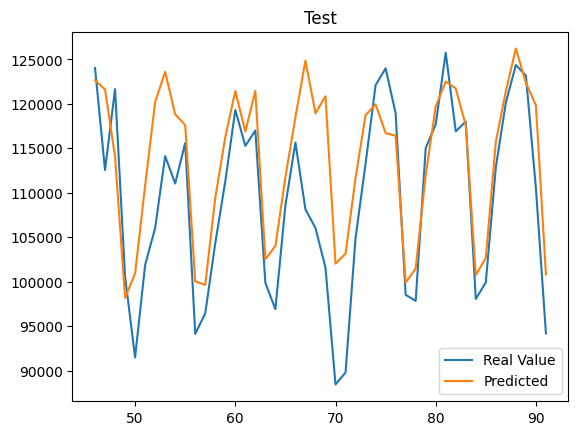

In [64]:
predict_visualizer(train_df, test_df, yhat_train, yhat_test)

### Evaluation

In [65]:
evaluation('Ridge Regression', train_df, test_df, yhat_train, yhat_test)

Ridge Regression train scores:
MAE : 31.86235749652385
MSE : 8709.575510207951
Ridge Regression test scores:
MAE : 39.090167800423515
MSE : 10359.034044407761
